This notebook attempts to solve the Assignment with a modular appraoch:
- utils to store all the general utility functions like plots and basic elements
- trainer which stores different flavours of lightning trainers
- augmentation which stores different data augmentation strategies
- dataloader which stores lightning dataloader
- model_helpers which contains prediction fn and gradcam fn

In [1]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch


In [3]:
from torchvision import datasets, transforms
from src.pytorch_base.helper import set_seed, get_device
from src.lightning_base.utils import (
    get_data_characteristics,
    show_rawdata,
    show_batchdata,
)
import matplotlib.pyplot as plt
from src.lightning_base.config import (
    classes,
    seed,
    mean,
    std,
    epochs,
    learning_rate,
    batch_size,
    num_workers,
    model_path
)
from src.paper_nets.resnet import ResNetX
from src.lightning_base.config import model_parameters, num_classes, img_channels
from torchinfo import summary
import lightning as L
from src.lightning_base.model_helper import (
    loss_metric_plot,
    prediction_loop,
    show_misclassified,
    find_mismatches,
)

from lightning.pytorch.callbacks import (
    EarlyStopping,
    DeviceStatsMonitor,
    ModelCheckpoint,
)
import torch
from src.lightning_base.dataloader import Cifar10DataModule
from src.lightning_base.model_helper import lightning_model_maker, find_best_lr

Random seed set as 111


In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Setting up basic training elements
set_seed(seed)
device = get_device()
print(device)

Random seed set as 111
cuda


## DataPrep

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
get_data_characteristics(train, "Train Dataset")
get_data_characteristics(test, "Test Dataset")

The data is [Train Dataset]
Total no of datapoints: 50000
The shape of the data: torch.Size([3, 32, 32])
The mean accross all channels: tensor([0.5537, 0.4122, 0.2511])
The stdev accross all channels: tensor([0.1595, 0.1665, 0.1603])
The min pixel value: 0.0
The max pixel value: 1.0


The data is [Test Dataset]
Total no of datapoints: 10000
The shape of the data: torch.Size([3, 32, 32])
The mean accross all channels: tensor([0.4315, 0.4344, 0.4093])
The stdev accross all channels: tensor([0.2062, 0.1429, 0.1927])
The min pixel value: 0.05098039284348488
The max pixel value: 1.0




<Figure size 1800x1080 with 0 Axes>

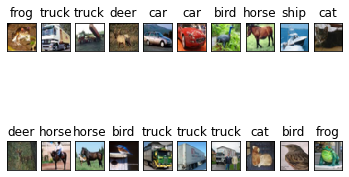

In [7]:
plt.figure(figsize=(25, 15))
show_rawdata(train, 20, classes)

In [8]:
dm = Cifar10DataModule(seed, mean, std)
dm.prepare_data()

# splits/transforms
dm.setup(stage="fit")

# use data
for batch in dm.train_dataloader():
    x_t, y_t = batch
    print(x_t.shape)
    print(y_t.shape)
    print(x_t.mean())
    print(x_t.std())
    break

dm.teardown(stage="fit")

dm.setup(stage="test")
for batch in dm.test_dataloader():
    x_v, y_v = batch
    print(x_v.shape)
    print(y_v.shape)
    print(x_v.mean())
    print(x_v.std())
    break

dm.teardown(stage="test")

Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32])
torch.Size([128])
tensor(0.0342)
tensor(0.9615)
torch.Size([128, 3, 32, 32])
torch.Size([128])
tensor(-0.0199)
tensor(1.0169)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


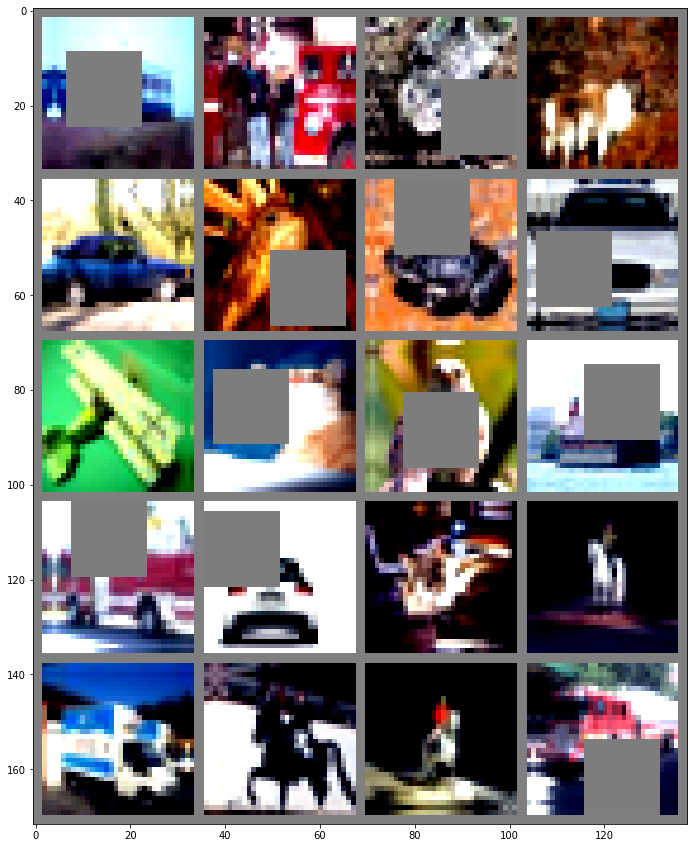

In [9]:
show_batchdata(x_t,20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


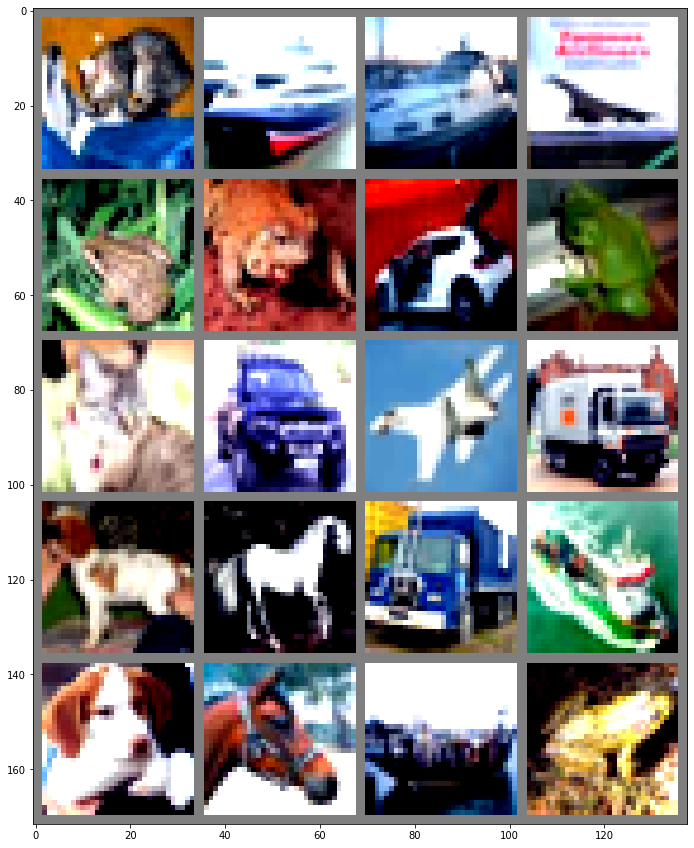

In [10]:
show_batchdata(x_v,20)

## Model Building
- Baseline model with only LR finder to get the baseline score
- Advanced model with callbacks for early stopping as well as LR scheduling

In [11]:
# seeting up the basic model
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"],
    img_channels=img_channels,
    num_classes=num_classes,
).to(device)

In [12]:
summary(resnet_model, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetX                                  [1, 10]                   --
├─ResnetPrepBlock: 1-1                   [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 16, 16]           128
│    └─ReLU: 2-3                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                    [1, 64, 8, 8]             --
├─Sequential: 1-2                        [1, 64, 8, 8]             --
│    └─ResnetBasicBlock: 2-5             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│

In [13]:
lightning_model, dm, trainer = lightning_model_maker(
    resnet_model,
    learning_rate,
    seed,
    mean,
    std,
    num_workers,
    batch_size,
    epochs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finding best initial lr:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
Learning rate set to 0.0009847666521101588
Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/.lr_find_3a8bcf07-cf3c-465a-9011-575196a86911.ckpt
Restored all states from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/.lr_find_3a8bcf07-cf3c-465a-9011-575196a86911.ckpt


0.0009847666521101588


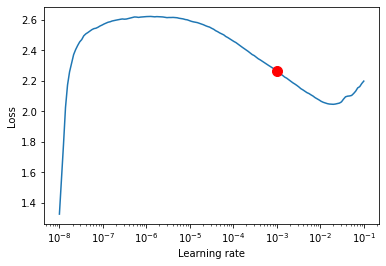

In [14]:
best_lr = find_best_lr(trainer, lightning_model, dm, learning_rate)
print(best_lr)

In [15]:
lightning_model, dm, trainer = lightning_model_maker(
    resnet_model,
    best_lr,
    seed,
    mean,
    std,
    num_workers,
    batch_size,
    epochs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
# fitting the model with custom datamodule
trainer.fit(model=lightning_model, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNetX            | 21.3 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [17]:
val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
test_acc = trainer.test(datamodule=dm)[0]["test_acc"]
print(f" | Val Acc {val_acc*100:.2f}%" f" | Test Acc {test_acc*100:.2f}%")

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at ./logs/Mnist_exp/version_73/checkpoints/epoch=9-step=690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_73/checkpoints/epoch=9-step=690.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6248666644096375     │
│         val_loss          │    1.0903840065002441     │
└───────────────────────────┴───────────────────────────┘

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at ./logs/Mnist_exp/version_73/checkpoints/epoch=9-step=690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_73/checkpoints/epoch=9-step=690.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6933000087738037     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 62.49% | Test Acc 69.33%


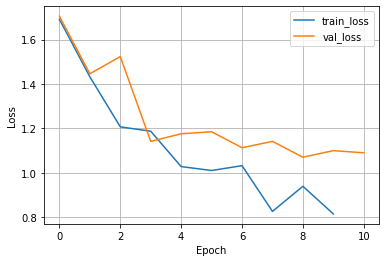

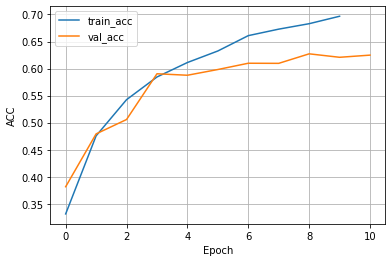

In [18]:
loss_metric_plot(trainer)

Adding a checkpoint for early stopping

In [19]:
# seeting up the basic model
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"],
    img_channels=img_channels,
    num_classes=num_classes,
).to(device)

In [20]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")

lightning_model, dm, trainer = lightning_model_maker(
    resnet_model,
    best_lr,
    seed,
    mean,
    std,
    num_workers,
    batch_size,
    epochs,
    callbacks = [early_stopping]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
# fitting the model with custom datamodule
trainer.fit(model=lightning_model, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNetX            | 21.3 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |                                                                                                 …

Metric val_loss improved. New best score: 1.632


Validation: |                                                                                                 …

Metric val_loss improved by 0.198 >= min_delta = 0.0. New best score: 1.434


Validation: |                                                                                                 …

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.422


Validation: |                                                                                                 …

Metric val_loss improved by 0.195 >= min_delta = 0.0. New best score: 1.228


Validation: |                                                                                                 …

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 1.145


Validation: |                                                                                                 …

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.077


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.031


Validation: |                                                                                                 …

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.940
`Trainer.fit` stopped: `max_epochs=10` reached.


In [22]:
val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
test_acc = trainer.test(datamodule=dm)[0]["test_acc"]
print(f" | Val Acc {val_acc*100:.2f}%" f" | Test Acc {test_acc*100:.2f}%")

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at ./logs/Mnist_exp/version_74/checkpoints/epoch=9-step=690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_74/checkpoints/epoch=9-step=690.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6666666865348816     │
│         val_loss          │    0.9418882727622986     │
└───────────────────────────┴───────────────────────────┘

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at ./logs/Mnist_exp/version_74/checkpoints/epoch=9-step=690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_74/checkpoints/epoch=9-step=690.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7195000052452087     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 66.67% | Test Acc 71.95%


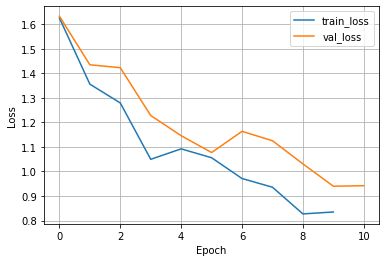

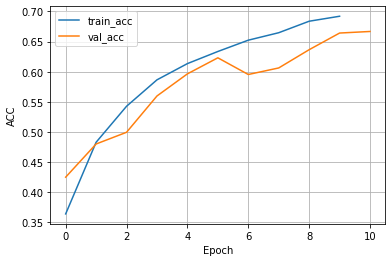

In [23]:
loss_metric_plot(trainer)

saving the model object and predicting and showcasing the misclassified images

In [24]:
# lightning_model.state_dict()

In [25]:
# lightning_model.model.state_dict()

In [26]:
torch.save(lightning_model.model.state_dict(), model_path)

In [27]:
# seeting up the basic model
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"],
    img_channels=img_channels,
    num_classes=num_classes,
).to(device)

In [28]:
resnet_model.load_state_dict(torch.load("./models/cifar10lightning.pt"))

<All keys matched successfully>

In [29]:
features, targets, predictions = prediction_loop(resnet_model, device, dm)

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [30]:
mismatch_indices = find_mismatches(targets, predictions)

In [31]:
mismatch_features = [
    feat for i, feat in enumerate(features) if i in list(mismatch_indices)
]
mis_targets = [feat for i, feat in enumerate(targets) if i in list(mismatch_indices)]

In [32]:
len(mismatch_features), len(mis_targets)

(2805, 2805)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


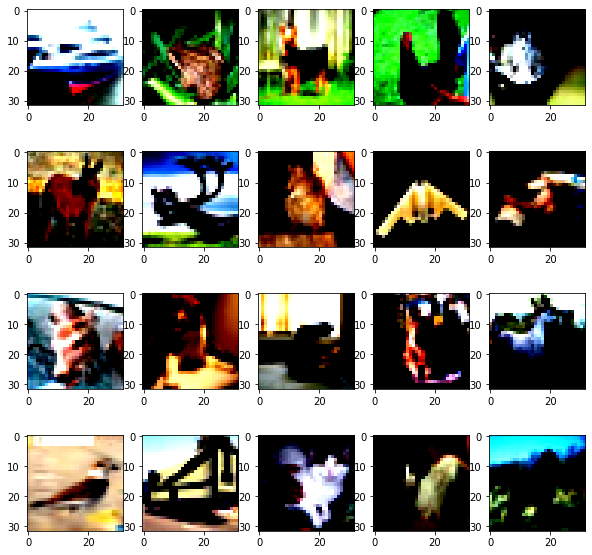

In [33]:
show_misclassified(mismatch_features, 20)

Grad Cam

In [38]:
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [34]:
target_layers = [resnet_model.layer4]

In [35]:
input_image = mismatch_features[0]
print(input_image.shape)
label = mis_targets[0]
print(label)

(32, 32, 3)
8


In [39]:
input_tensor = torch.from_numpy(input_image).to(device)

In [45]:
input_tensor = input_tensor.permute(2,0,1).squeeze(0)
print(input_tensor.s)

In [46]:
cam = GradCAM(model=resnet_model, target_layers=target_layers)

In [47]:
grayscale_cam = cam(input_tensor=input_tensor, targets=label)

ValueError: expected 4D input (got 3D input)

In [ ]:
grayscale_cam = grayscale_cam[0, :]

# Get back the original image
img = input_tensor.squeeze(0).to("cpu")
img = inv_normalize(img)
rgb_img = np.transpose(img, (1, 2, 0))
rgb_img = rgb_img.numpy()

# Mix the activations on the original image
visualization = show_cam_on_image(
    rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency
)

# Display the images on the plot
plt.imshow(visualization)

In [ ]:

def gardcam_imageprep(img, mean, std):
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=mean, std=std)

    return img, input_tensor


def grad_cam_trainer(model, target_layers, image, input_tensor, prediction_label):
    # model targets
    targets = [ClassifierOutputTarget(prediction_label)]
    # grad cam
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)

    #  image display
    cam = np.uint8(255 * grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    cam_images = np.hstack((np.uint8(255 * image), cam, cam_image))

    return cam_images

In [ ]:
img, input_tensor = gardcam_imageprep(input_image, mean, std)
op = grad_cam_trainer(resnet_model, target_layers, img, input_tensor, label)

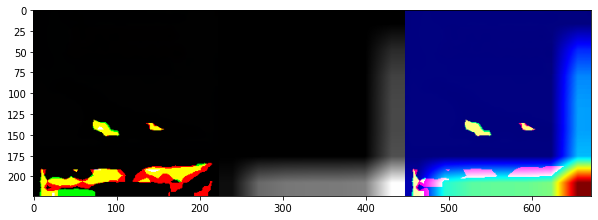

In [ ]:
plt.figure(figsize=(10, 9))
plt.imshow(op)